# Value of disagreement in crowdsourced policymaking

In this notebook we explore the value of disagreement in crowdsourced policymaking by addressing the following research questions.

## Research Questions

1. **RQ1.** What are the predictors of disagreement?
2. **RQ2.** What are the predictors of new ideas?
3. **RQ3.** How does the presence of both disagreement and agreement affect new idea generation? (if disagreement and agreement are present simultaneously, in the same comment/thread?)
4. **RQ4.** Do comments with only disagreement/only agreement lead to more new idea generation?

## Methodology

To address RQ1 and RQ2, numeric variables computed during the qualitative analysis are considered. As the first step, we propose to conduct correlation analyses to understand collinearity between variables. Collinearity between variables might produce incorrect inferences about the association between predictors and the response variable. To address RQ1, logistic regression is employed to model the relationship between predictors and the variable disagreement. Variables that are found to be highly-correlated are not included in the analysis. In answering RQ2, multi-variate linear regression is applied to learn the relationship between predictors and the generation of new ideas. As in the case of RQ1, highly-correlated variables will be excluded from the analysis.

RQ3 is answered by fitting a logistic regression model in which the response variable is whether or not the new ideas are produced while the explanatory variables are agreement and disagreement.

For RQ4, we check the number of comments in which new ideas are produced when there is agreement or disagreement. Also, we count the number of ideas produced in comments than contain agreement and disagreement. Inferential statistics (e.g., student’s t-test) is conducted on the means of ideas produced on comments with agreement and disagreement to understand whether there is a significant difference in the number of ideas produced when agreements are present or vice versa.

## Load libraries

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

from collections import defaultdict
from predictor import predict_disagreement
from statsmodels.formula.api import glm
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use('seaborn')

## Load data

### Topic: Member decision making and right

In [2]:
member_df = pd.read_csv('data/member_decision_making_and_right.csv')
nrows, ncols = member_df.shape
print(f'The dataset has {nrows} rows and {ncols} columns')

The dataset has 213 rows and 51 columns


#### Columns

In [126]:
member_df.columns

Index(['background', 'proposals', 'time', 'user_id', 'user_email', 'user_name',
       'comment_id', 'comment', 'response_id', 'response', 'number_of_likes',
       'users_who_liked', 'attachments', 'comment_1', 'response_1', 'topic_1',
       'topic_2', 'topic_3', 'disagreement', 'agreement',
       'simple_disagreement', 'elaborated_disagreement', 'simple_agreement',
       'elaborated_agreement', 'idea_s', 'number_of_ideas', 'new_idea',
       'sourcing', 'value_s', 'topic_shift', 'brainstorming', 'blending',
       'building', 'broadening', 'fact', 'value', 'policy', 'interpretation',
       'target_of_disagreement', 'target_of_agreement', 'gives_reason_s',
       'presents_evidence', 'asks_question_s', 'provides_information',
       'clarifies_position_stance', 'responds_to_previous_comment',
       'constructive_tone', 'moderator_post', 'acknowledges_problem', 'notes',
       'annotations_for_disagreement_new_idea_cascades', 'topic'],
      dtype='object')

### Topic: Administration of an association

In [3]:
admin_df = pd.read_csv('data/administration_of_association.csv')
nrows, ncols = admin_df.shape
print(f'The dataset has {nrows} rows and {ncols} columns')

The dataset has 119 rows and 51 columns


#### Columns

In [5]:
admin_df.columns

Index(['Background', 'Proposal', 'Time', 'User ID', 'User email', 'User name',
       'Comment's ID', 'Comment', 'Response ID', 'Response', 'Amount of likes',
       'Users who liked', 'Attachments', 'Comment.1', 'Response.1', 'Topic 1',
       'Topic 2', 'Topic 3', 'disagreement', 'agreement',
       'simple disagreement', 'elaborated disagreement', 'simple agreement',
       'elaborated agreement', 'idea(s)', 'number of ideas', 'new idea',
       'sourcing', 'value(s)', 'topic shift', 'brainstorming', 'blending',
       'building', 'broadening', 'fact', 'value', 'policy', 'interpretation',
       'target of disagreement', 'target of agreement', 'gives reason(s)',
       'presents evidence', 'asks question(s)', 'provides information',
       'clarifies position/stance', 'responds to previous comment',
       'constructive tone', 'moderator post', 'acknowledges problem', 'notes',
       'annotations for disagreement / new idea cascades'],
      dtype='object')

### Topic: Informally organized groups of an association

In [4]:
informal_df = pd.read_csv('data/informally_organized_group_of_a.csv')
nrows, ncols = informal_df.shape
print(f'The dataset has {nrows} rows and {ncols} columns')

The dataset has 159 rows and 53 columns


#### Columns

In [7]:
informal_df.columns

Index(['Background', 'Proposal', 'Time', 'User ID', 'User email', 'User name',
       'Comment ID', 'Comment', 'Response ID', 'Response', 'Number of likes',
       'Users who liked', 'Attachments', 'Comment.1', 'Response.1', 'Topic 1',
       'Topic 2', 'Topic 3', 'disagreement', 'agreement',
       'simple disagreement', 'elaborated disagreement', 'simple agreement',
       'elaborated agreement', 'idea(s)', 'number of ideas', 'new idea',
       'sourcing', 'value(s)', 'topic shift', 'brainstorming', 'blending',
       'building', 'broadening', 'fact', 'value', 'policy', 'IRRpolicy',
       'interpretation', 'IRRinterpretation', 'target of disagreement',
       'target of agreement', 'gives reason(s)', 'presents evidence',
       'asks question(s)', 'provides information', 'clarifies position/stance',
       'responds to previous comment', 'constructive tone',
       'IRRconstructive tone', 'moderator post', 'acknowledges problem',
       'annotations for disagreement / new idea casca

## Preprocess data

### Normalize column names

Put column names to lower case, replace spaces with underscore, delete leading and trailing spaces, and remove non alpha-numerical characters

In [5]:
def normalize_column_names(names):
    names = names.str.lower()
    names = names.str.replace(' ','_')
    names = names.str.replace('.','_')
    names = names.str.replace('(','_')
    names = names.str.replace(')','')
    names = names.str.replace('/','_')
    names = names.str.replace('___','_')
    names = names.str.strip()
    return names

In [6]:
member_df.columns = normalize_column_names(member_df.columns)
admin_df.columns = normalize_column_names(admin_df.columns)
informal_df.columns = normalize_column_names(informal_df.columns)

### Standarize column names

Columns that contained the same information but have slightly different names are renamed for compatibility purposes

In [7]:
member_df = member_df.rename(columns={
    'annotations_for_disagreement_new_idea_cascade_s': 'annotations_for_disagreement_new_idea_cascades'
})

In [8]:
admin_df = admin_df.rename(columns={
    'amount_of_likes': 'number_of_likes',
    'comment\'s_id': 'comment_id',
    'proposal': 'proposals',    
})

In [9]:
informal_df = informal_df.rename(columns={
    'annotations_for_disagreement_new_idea_cascade_s': 'annotations_for_disagreement_new_idea_cascades',
    'proposal': 'proposals'
})

### Merge datasets in one dataframe

Add an extra column to indicate the discussion topic

In [10]:
member_df['topic'] = 'member'
admin_df['topic'] = 'admin'
informal_df['topic'] = 'informal'

Merge datasets

In [11]:
all_df = pd.concat([member_df, admin_df, informal_df], axis=0, ignore_index=True)

In [12]:
nrows, ncols = all_df.shape
print(f'The merged dataset has {nrows} rows and {ncols} columns')

The merged dataset has 491 rows and 55 columns


In [16]:
all_df.columns

Index(['background', 'proposals', 'time', 'user_id', 'user_email', 'user_name',
       'comment_id', 'comment', 'response_id', 'response', 'number_of_likes',
       'users_who_liked', 'attachments', 'comment_1', 'response_1', 'topic_1',
       'topic_2', 'topic_3', 'disagreement', 'agreement',
       'simple_disagreement', 'elaborated_disagreement', 'simple_agreement',
       'elaborated_agreement', 'idea_s', 'number_of_ideas', 'new_idea',
       'sourcing', 'value_s', 'topic_shift', 'brainstorming', 'blending',
       'building', 'broadening', 'fact', 'value', 'policy', 'interpretation',
       'target_of_disagreement', 'target_of_agreement', 'gives_reason_s',
       'presents_evidence', 'asks_question_s', 'provides_information',
       'clarifies_position_stance', 'responds_to_previous_comment',
       'constructive_tone', 'moderator_post', 'acknowledges_problem', 'notes',
       'annotations_for_disagreement_new_idea_cascades', 'topic', 'irrpolicy',
       'irrinterpretation', 'irrc

### Remove columns containing text in Finnish

Text of comments and responses are both in Finnish and English. Columns `comment` and `response` that contain text in Finnish are removed because they will not be considered in this analysis.

In [13]:
all_df = all_df.drop(['comment', 'response'], axis=1)

Columns `comment_1` and `response_1` are renamed removing `_1` from their names

In [14]:
all_df = all_df.rename(columns={'comment_1': 'comment', 'response_1': 'response'})

**Final columns**

In [19]:
all_df.columns

Index(['background', 'proposals', 'time', 'user_id', 'user_email', 'user_name',
       'comment_id', 'response_id', 'number_of_likes', 'users_who_liked',
       'attachments', 'comment', 'response', 'topic_1', 'topic_2', 'topic_3',
       'disagreement', 'agreement', 'simple_disagreement',
       'elaborated_disagreement', 'simple_agreement', 'elaborated_agreement',
       'idea_s', 'number_of_ideas', 'new_idea', 'sourcing', 'value_s',
       'topic_shift', 'brainstorming', 'blending', 'building', 'broadening',
       'fact', 'value', 'policy', 'interpretation', 'target_of_disagreement',
       'target_of_agreement', 'gives_reason_s', 'presents_evidence',
       'asks_question_s', 'provides_information', 'clarifies_position_stance',
       'responds_to_previous_comment', 'constructive_tone', 'moderator_post',
       'acknowledges_problem', 'notes',
       'annotations_for_disagreement_new_idea_cascades', 'topic', 'irrpolicy',
       'irrinterpretation', 'irrconstructive_tone'],
      d

### Check null values

Check the number of null values by columns

In [20]:
all_df.isnull().sum()

background                                          3
proposals                                           3
time                                                3
user_id                                             3
user_email                                          3
user_name                                           3
comment_id                                        346
response_id                                       148
number_of_likes                                     0
users_who_liked                                   263
attachments                                       491
comment                                           348
response                                          146
topic_1                                             4
topic_2                                           147
topic_3                                           358
disagreement                                        0
agreement                                           0
simple_disagreement         

## RQ1. Predictors of disagreement

### Methodology

To understand which variables best predict disagreement logistic regression is applied through the following procedure:

1. Select the explanatory variables or predictors of interest (all of the available in this case). The terms predictors and variables are used interchangeable from here;
2. Cast predictors to numeric type ensuring that categorical predictors contain only binary values (1/0). Records in which categorical predictors contain values different from 0 or 1 are discarded;
3. Compute correlation between the numerical predictors number of likes and number of ideas. Because the distribution values in the numerical variables does not follow a normal distribution, the non-parametric Spearman correlation method is used. Predictors that are not independent should not be included together in logistic regression models;
4. Compute correlation between numerical and categorical variables. [Point-biserial correlation](https://www.statisticssolutions.com/point-biserial-correlation/) is used to understand the independence between categorical and numerical predictors. Predictors that are not independent should be included together in models;
5. Cast categorical predictors to category type so later the correlation between these variable can be computed;
6. Compute correlation between categorical predictors. Not independent predictors should not be included together in models;
7. Fit logistic regression models considering all possible combinations of independent predictors;
8. Select the best model and interpret the coefficients.

### 1. Define and select predictor variables for `disagreement`

In [17]:
predictors_disagreement = [
    'number_of_likes', 'number_of_ideas', 'simple_disagreement', 'elaborated_disagreement',
    'topic_shift', 'brainstorming', 'blending', 'building', 'broadening', 'fact',
    'value', 'policy', 'interpretation', 'gives_reason_s', 'presents_evidence', 'asks_question_s',
    'provides_information', 'clarifies_position_stance', 'responds_to_previous_comment', 
    'constructive_tone', 'moderator_post', 'acknowledges_problem'
]
print(f"In total {len(predictors_disagreement)} variables will be considered in the analysis of RQ1")

In total 22 variables will be considered in the analysis of RQ1


#### Select columns that include predictors and the target variable

In [119]:
rq1_df = all_df.loc[:,predictors_disagreement+['disagreement']]
print(f"The analysis is conducted with a dataset composed of {rq1_df.shape[0]} rows and {rq1_df.shape[1]} columns")

The analysis is conducted with a dataset composed of 491 rows and 23 columns


### 2. Cast variables to numeric

Some variables have the values `unclear` and `nan`, which need to be converted to numerical before casting the variable to this type.

In [16]:
numerical_predictors = ['number_of_likes', 'number_of_ideas']

In [121]:
for col in rq1_df.columns:
    rq1_df.loc[rq1_df[col]=='unclear', col] = 0
    rq1_df.loc[rq1_df[col].isna(), col] = 0
    rq1_df[col] = pd.to_numeric(rq1_df[col], downcast='unsigned')
    if col not in numerical_predictors:
        unique_values = rq1_df[col].unique()
        invalid_values = set(unique_values) - set([0,1])
        if len(invalid_values) > 0:  # the column has invalid values                   
            invalid_indexes = list(rq1_df.loc[~rq1_df[col].isin([0,1])].index)
            if len(invalid_indexes) > 0:
                print(f'Found the following invalid values {invalid_values} in {len(invalid_indexes)} rows of the column {col}. Rows has been discarded.')
                rq1_df = rq1_df.drop(index=invalid_indexes)            

Found the following invalid values {13, 6, 7} in 3 rows of the column simple_disagreement. Rows has been discarded.


/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [122]:
print(f"After the step above the dataset is composed of {rq1_df.shape[0]} rows and {rq1_df.shape[1]} columns")

After the step above the dataset is composed of 488 rows and 23 columns


#### Check variable types

In [26]:
rq1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 489
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   number_of_likes               488 non-null    uint8 
 1   number_of_ideas               488 non-null    uint16
 2   simple_disagreement           488 non-null    uint8 
 3   elaborated_disagreement       488 non-null    uint8 
 4   topic_shift                   488 non-null    uint8 
 5   brainstorming                 488 non-null    uint8 
 6   blending                      488 non-null    uint8 
 7   building                      488 non-null    uint8 
 8   broadening                    488 non-null    uint8 
 9   fact                          488 non-null    uint8 
 10  value                         488 non-null    uint8 
 11  policy                        488 non-null    uint8 
 12  interpretation                488 non-null    uint8 
 13  gives_reason_s      

### 3. Check independence between numerical variables

We use Persons correlation to find out whether the numerical variables `number_of_likes` and `number_of_ideas` are correlated.

In [27]:
alpha_level = 0.05

Distribution of `number_of_likes`

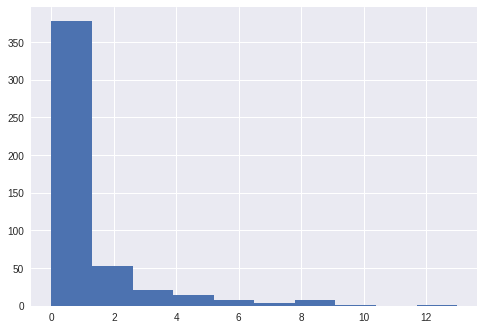

In [28]:
rq1_df['number_of_likes'].hist()

Distribution of `number_of_ideas`

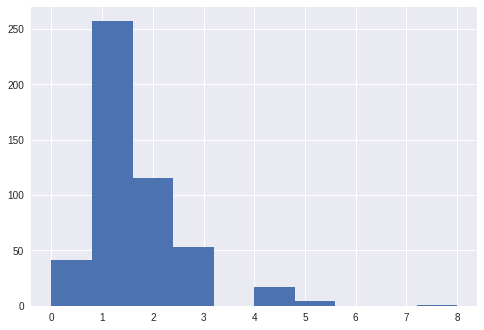

In [29]:
rq1_df['number_of_ideas'].hist()

Because data are not distributed normally, a non-parametric correlation method is used

In [30]:
pearson_stat, p_val = stats.spearmanr(rq1_df['number_of_likes'], rq1_df['number_of_ideas'])

In [31]:
if p_val < alpha_level:
    print(f'Numerical variables are not independent, p-value: {round(p_val,3)}.')
else:
    print(f'Numerical variables are independent, p-value: {round(p_val,3)}.')

Numerical variables are not independent, p-value: 0.011.


Numerical variables are not independent, so they cannot be included together in models.

### 4. Check independence between numerical and categorical variables

Persons correlation is employed to analyze correlation between numerical and categorical variables. Having dichotomous categorical variables, Persons correlation can be used [ref](https://www.researchgate.net/post/Can_I_use_Pearsons_correlation_coefficient_to_know_the_relation_between_perception_and_gender_age_income). 

In [32]:
independence_num_cat = pd.DataFrame(columns=numerical_predictors, index=predictors_disagreement)
independence_num_cat_vars = defaultdict(list)
for predictor_1 in numerical_predictors:    
    for predictor_2 in predictors_disagreement:        
        if predictor_2 == predictor_1:
            continue
        pearson_stat, p_val = stats.spearmanr(rq1_df[predictor_1],rq1_df[predictor_2])        
        if p_val < alpha_level:
            independence_num_cat.loc[predictor_2,predictor_1] = 'F'
        else:
            independence_num_cat.loc[predictor_2,predictor_1] = 'T'
            independence_num_cat_vars[predictor_1].append(predictor_2)

In [33]:
independence_num_cat

,number_of_likes,number_of_ideas
number_of_likes,NaN,F
number_of_ideas,F,NaN
simple_disagreement,T,F
elaborated_disagreement,F,F
topic_shift,F,F
brainstorming,F,F
blending,F,F
building,F,F
broadening,T,F
fact,F,T


`number_of_likes` is independent from

In [34]:
independence_num_cat_vars['number_of_likes']

['simple_disagreement',
 'broadening',
 'value',
 'policy',
 'presents_evidence',
 'provides_information',
 'constructive_tone',
 'acknowledges_problem']

`number_of_ideas` is independent from

In [35]:
independence_num_cat_vars['number_of_ideas']

['fact',
 'presents_evidence',
 'asks_question_s',
 'provides_information',
 'responds_to_previous_comment',
 'constructive_tone']

### 5. Cast categorical variables to category type

In [36]:
for col in rq1_df.columns:
    if col not in numerical_predictors:
        rq1_df[col] = rq1_df[col].astype('category')

In [37]:
rq1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 489
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   number_of_likes               488 non-null    uint8   
 1   number_of_ideas               488 non-null    uint16  
 2   simple_disagreement           488 non-null    category
 3   elaborated_disagreement       488 non-null    category
 4   topic_shift                   488 non-null    category
 5   brainstorming                 488 non-null    category
 6   blending                      488 non-null    category
 7   building                      488 non-null    category
 8   broadening                    488 non-null    category
 9   fact                          488 non-null    category
 10  value                         488 non-null    category
 11  policy                        488 non-null    category
 12  interpretation                488 non-null    cate

### 6. Check independence of categorial variables

In [38]:
independece_analysis = pd.DataFrame(columns=predictors_disagreement, index=predictors_disagreement)
for predictor_1 in predictors_disagreement:
    if predictor_1 in numerical_predictors:
        continue
    for predictor_2 in predictors_disagreement:        
        if predictor_2 in numerical_predictors:
            continue
        if predictor_2 == predictor_1:
            continue
        cross_tab = pd.crosstab(rq1_df[predictor_1],rq1_df[predictor_2])
        chi2_stat, p_val, dof, ex = stats.chi2_contingency(cross_tab)
        if p_val < alpha_level:
            independece_analysis.loc[predictor_1,predictor_2] = 'F'
        else:
            independece_analysis.loc[predictor_1,predictor_2] = 'T'

In [39]:
independece_analysis.drop(columns=numerical_predictors, index=numerical_predictors, inplace=True)
independece_analysis

,simple_disagreement,elaborated_disagreement,topic_shift,brainstorming,blending,building,broadening,fact,value,policy,interpretation,gives_reason_s,presents_evidence,asks_question_s,provides_information,clarifies_position_stance,responds_to_previous_comment,constructive_tone,moderator_post,acknowledges_problem
simple_disagreement,NaN,F,T,F,T,T,F,T,F,F,T,F,T,T,T,T,T,F,T,F
elaborated_disagreement,F,NaN,T,F,T,F,T,F,F,F,F,F,F,F,T,F,F,T,F,T
topic_shift,T,T,NaN,F,T,F,F,T,T,F,T,T,T,T,T,F,F,T,T,T
brainstorming,F,F,F,NaN,F,T,F,T,T,T,T,F,T,T,T,T,F,F,T,T
blending,T,T,T,F,NaN,T,T,T,F,F,T,F,T,F,T,T,F,T,T,F
building,T,F,F,T,T,NaN,T,F,T,F,F,F,F,F,F,F,F,T,F,T
broadening,F,T,F,F,T,T,NaN,T,F,T,T,F,F,T,F,T,T,T,F,F
fact,T,F,T,T,T,F,T,NaN,T,T,F,F,F,T,T,F,F,T,T,T
value,F,F,T,T,F,T,F,T,NaN,F,F,F,F,T,T,T,T,T,T,F
policy,F,F,F,T,F,F,T,T,F,NaN,T,F,T,T,F,T,F,T,F,F


### 7. Fit models based on independent predictors

Based on the previous analysis of independencie between categorical variables, predictors will be selected.

In [40]:
possible_models = [None]*len(independece_analysis.columns)
idx = 0
for col in independece_analysis.columns:
    possible_models[idx] = [col]
    for row in independece_analysis.index:
        if independece_analysis.loc[row, col] == 'T':
            possible_models[idx].append(row)
    # Add independent numerical variables
    for num_var, ind_cat_vars in independence_num_cat_vars.items():        
        if col in ind_cat_vars:
            possible_models[idx].append(num_var)
            # After adding a numerical variable to the model
            # we break loop because both numerical variables 
            # cannot be together in a model since they are
            # not independent
            break
    idx += 1

In [41]:
print(f'There are {len(possible_models)} possible models')

There are 20 possible models


Create formulas for the possible models

In [51]:
models = []
for possible_model in possible_models:
    formula = f'disagreement ~ '
    num_predictors = len(possible_model)
    for idx, predictor in enumerate(possible_model):
        if predictor not in numerical_predictors:
            formula += f' C({predictor})'
        else:
            formula += f' {predictor}'
        if idx < (len(possible_model)-1):
            formula += ' + '
    models.append({'formula': formula, 'num_predictors': num_predictors, 'predictors': possible_model})

#### Fit models

In [52]:
idx_not_fitted_models = []
for idx, model_dict in enumerate(models):
    try:
        formula = model_dict['formula']
        model = glm(formula, data = rq1_df, family = sm.families.Binomial()).fit()
        model_dict['model'] = model
        model_dict['deviance'] = model.deviance
        model_dict['log_likelihood'] = model.llf 
        #models.append(model)
    except Exception as e:
        idx_not_fitted_models.append(idx)
        print(f'Error: {e}.\n\nModel:\n{formula}')
        print()

Error: Perfect separation detected, results not available.

Model:
disagreement ~  C(provides_information) +  C(simple_disagreement) +  C(elaborated_disagreement) +  C(topic_shift) +  C(brainstorming) +  C(blending) +  C(fact) +  C(value) +  C(interpretation) +  C(presents_evidence) +  C(asks_question_s) +  C(clarifies_position_stance) +  C(responds_to_previous_comment) +  C(constructive_tone) +  C(acknowledges_problem) +  number_of_likes



The perfect separation error happens when all values in one of the predictor categories are associated with only one of the binary outcome, see [here](https://stackoverflow.com/questions/53041669/error-perfectseparationerror-perfect-separation-detected-results-not-availab). A possible solution, which is executed below, is to drop predictors one by one and try if the resulting model can be fitted.

In [53]:
updated_models = []
for idx_not_fitted_model in idx_not_fitted_models:
    predictors = possible_models[idx_not_fitted_model].copy()
    for predictor in predictors:
        ind_vars = possible_models[idx_not_fitted_model].copy()        
        ind_vars.remove(predictor)
        formula = 'disagreement ~ '
        for idx, ind_var in enumerate(ind_vars):
            if ind_var not in numerical_predictors:
                formula += f' C({ind_var})'
            else:
                formula += f' {ind_var}'
            if idx < (len(ind_vars)-1):
                formula += ' + '
        try:
            model = glm(formula, data = rq1_df, family = sm.families.Binomial()).fit()
            print(f'Variable {predictor} has been removed from the predictors list and the model could be fitted.\n')
            updated_models.append(
                {
                    'formula': formula, 
                    'model': model, 
                    'num_predictors': len(ind_vars),
                    'predictors': ind_vars,
                    'deviance': model.deviance,
                    'log_likelihood': model.llf
                }
            )
        except:
            pass

Variable simple_disagreement has been removed from the predictors list and the model could be fitted.

Variable elaborated_disagreement has been removed from the predictors list and the model could be fitted.

Variable value has been removed from the predictors list and the model could be fitted.

Variable number_of_likes has been removed from the predictors list and the model could be fitted.



In [54]:
print(f'{len(updated_models)} new models could be fitted')

4 new models could be fitted


Update list of fitted models

In [55]:
models.extend(updated_models)

### 8. Select the best model

Selection is based on the goodness of fit. `Deviance`, which is measuse of error of fit, is used to evaluate models fit. The lower the deviance the better the model fits the data. 

In [104]:
min_dev = 1000000
best_models = []
for model in models:
    if 'deviance' in model and model['deviance'] < min_dev:
        min_dev = model['deviance']
        best_models = [model]
    elif 'deviance' in model and model['deviance'] == min_dev:
        best_models.append(model)

In [105]:
print(f"There are {len(best_models)} best model(s)")

There are 1 best model(s)


**Best model**

In [106]:
best_models[0]['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Generalized Linear Model Regression Results                            
==================================================================================================
Dep. Variable:     ['disagreement[0]', 'disagreement[1]']   No. Observations:                  488
Model:                                                GLM   Df Residuals:                      475
Model Family:                                    Binomial   Df Model:                           12
Link Function:                                      logit   Scale:                          1.0000
Method:                                              IRLS   Log-Likelihood:                -41.132
Date:                                    Fri, 17 Jul 2020   Deviance:                       82.263
Time:                                            10:49:03   Pearson chi2:                     315.
No. Iterations:                                         9                                         
Covariance Type:                                nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                1.2262      1.246      0.984      0.325      -1.215       3.668
C(broadening)[T.1]                       3.5808      1.327      2.699      0.007       0.980       6.182
C(elaborated_disagreement)[T.1]        -10.0362      1.739     -5.771      0.000     -13.445      -6.627
C(blending)[T.1]                         2.3335      0.896      2.603      0.009       0.577       4.090
C(building)[T.1]                        -4.6833      0.955     -4.902      0.000      -6.556      -2.811
C(fact)[T.1]                             0.4740      1.004      0.472      0.637      -1.495       2.443
C(policy)[T.1]                          -4.9299      1.392     -3.542      0.000      -7.658      -2.202
C(interpretation)[T.1]                   0.7207      0.952      0.757      0.449      -1.146       2.587
C(asks_question_s)[T.1]                  0.6177      1.023      0.604      0.546      -1.388       2.624
C(clarifies_position_stance)[T.1]        2.5304      1.206      2.098      0.036       0.167       4.894
C(responds_to_previous_comment)[T.1]     0.0267      0.857      0.031      0.975      -1.654       1.707
C(constructive_tone)[T.1]                6.1215      1.672      3.661      0.000       2.844       9.399
number_of_likes                          0.1627      0.171      0.954      0.340      -0.172       0.497
========================================================================================================
"""

Predictors `broadening`, `elaborated disagreement`, `blending`, `bulding`, `policy`, `clarifies position stance`, and `constructive tone` have a statistical significant effect on `disagreement`. The rest of the predictors (i.e., fact, interpretation, asks questions, clarifies position, constructive tone, and number of likes) do not influence significantly in the presence of disagreement in discussions.

**Interpretation of predictors' effect**

In [107]:
best_models[0]['model'].params

Intercept                                1.226194
C(broadening)[T.1]                       3.580829
C(elaborated_disagreement)[T.1]        -10.036193
C(blending)[T.1]                         2.333453
C(building)[T.1]                        -4.683274
C(fact)[T.1]                             0.473982
C(policy)[T.1]                          -4.929909
C(interpretation)[T.1]                   0.720706
C(asks_question_s)[T.1]                  0.617669
C(clarifies_position_stance)[T.1]        2.530369
C(responds_to_previous_comment)[T.1]     0.026706
C(constructive_tone)[T.1]                6.121526
number_of_likes                          0.162680
dtype: float64

In [108]:
# Convert from log odds to odds (only significant predictors are converted)
broadening = np.exp(best_models[0]['model'].params[1])
elaborated_disagreement = np.exp(best_models[0]['model'].params[2])
blending = np.exp(best_models[0]['model'].params[3])
building = np.exp(best_models[0]['model'].params[4])
policy = np.exp(best_models[0]['model'].params[6])
clarifies = np.exp(best_models[0]['model'].params[9])
constructive = np.exp(best_models[0]['model'].params[11])

Broadening

In [109]:
print(f"The odds that disagreement appears in a discussion where there is diversity of perspectives "\
      f"(broadening) are {round(broadening,2)} times the odds that disagreement appears in a discussion "\
      f"without diverse perspectives")

The odds that disagreement appears in a discussion where there is diversity of perspectives (broadening) are 35.9 times the odds that disagreement appears in a discussion without diverse perspectives


Elaborated Disagreement

In [125]:
print(f"The odds that disagreement appears in a discussion with elaborated disagreement are "\
      f"{round(elaborated_disagreement,4)} times the odds that disagreement appears in a "\
      f"discussion without elaborated disagreement.")

The odds that disagreement appears in a discussion with elaborated disagreement are 0.0 times the odds that disagreement appears in a discussion without elaborated disagreement.


Blending

In [111]:
print(f"The odds that disagreement appears in a discussion where diverse ideas are integrated (blending)"\
      f" are {round(blending,2)} times the odds that disagreement appears in a discussion without the "\
      f"integration of diverse ideas.")

The odds that disagreement appears in a discussion where diverse ideas are integrated (blending) are 10.31 times the odds that disagreement appears in a discussion without the integration of diverse ideas.


Building

In [112]:
print(f"The odds that disagreement appears in a discussion where participants build upon others' ideas "\
      f"are {round(building,2)} times the odds that disagreement appears in a discussion without building.")

The odds that disagreement appears in a discussion where participants build upon others' ideas are 0.01 times the odds that disagreement appears in a discussion without building.


Policy

In [113]:
print(f"The odds that disagreement appears in a discussion that includes exchange of comments about policies are "\
      f"{round(policy,2)} times the odds that disagreement appears in a discussion without exchange of "\
      f"comments about policies.")

The odds that disagreement appears in a discussion that includes exchange of comments about policies are 0.01 times the odds that disagreement appears in a discussion without exchange of comments about policies.


Clarifies

In [114]:
print(f"The odds that disagreement appears in a discussion in which commenter clarified o elaborated on a " \
      f"position are {round(clarifies,2)} times the odds that disagreement appears in a discussion without " \
      f"clarifications.")

The odds that disagreement appears in a discussion in which commenter clarified o elaborated on a position are 12.56 times the odds that disagreement appears in a discussion without clarifications.


Constructive Tone

In [123]:
print(f"The odds that disagreement appears in a discussion with constructive tone are {round(constructive,2)} " \
      f"times the estimates odds that disagreement appears in a discussion without constructive tone.")

The odds that disagreement appears in a discussion with constructive tone are 455.56 times the estimates odds that disagreement appears in a discussion without constructive tone.


#### Findings

The model that better models the presence/absence of disagreement is composed of the variables broadening, elaborated disagreement, blending, bulding, policy, clarifies position/stance, constructive tone, fact, interpretation, asks questions, clarifies position, constructive tone, and number of likes. Not all predictors influence significantly into the presence/absence of disagreement. Among the predictors that influence significantly the most influencials are (ordered from the most influencial to the less influencial): constructive tone, broadening, clarifies, blending, building, policy, and elaborated disagreement.

## RQ1. Predictors of disagreement by discussion theme

### Theme: Member

In [19]:
categorical_predictors = predictors_disagreement.copy()
for numerical_predictor in numerical_predictors:
    categorical_predictors.remove(numerical_predictor)
print(categorical_predictors)

['simple_disagreement', 'elaborated_disagreement', 'topic_shift', 'brainstorming', 'blending', 'building', 'broadening', 'fact', 'value', 'policy', 'interpretation', 'gives_reason_s', 'presents_evidence', 'asks_question_s', 'provides_information', 'clarifies_position_stance', 'responds_to_previous_comment', 'constructive_tone', 'moderator_post', 'acknowledges_problem']


In [29]:
best_models = predict_disagreement(all_df, categorical_predictors, numerical_predictors, theme='member')

The analysis is conducted with a dataset composed of 213 rows and 23 columns
Found the following invalid values {6} in 1 rows of the column simple_disagreement. Rows has been discarded.
After the step above the dataset is composed of 212 rows and 23 columns
There are 20 possible models
Error: Perfect separation detected, results not available.
Model:
disagreement ~  C(topic_shift) +  C(simple_disagreement) +  C(elaborated_disagreement) +  C(brainstorming) +  C(blending) +  C(building) +  C(broadening) +  C(fact) +  C(value) +  C(policy) +  C(interpretation) +  C(gives_reason_s) +  C(presents_evidence) +  C(asks_question_s) +  C(provides_information) +  C(constructive_tone) +  C(acknowledges_problem) +  number_of_likes +  number_of_ideas

Error: Perfect separation detected, results not available.
Model:
disagreement ~  C(brainstorming) +  C(simple_disagreement) +  C(elaborated_disagreement) +  C(topic_shift) +  C(blending) +  C(building) +  C(fact) +  C(value) +  C(policy) +  C(interpre

**Best model**

In [30]:
best_models[0]['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Generalized Linear Model Regression Results                            
==================================================================================================
Dep. Variable:     ['disagreement[0]', 'disagreement[1]']   No. Observations:                  212
Model:                                                GLM   Df Residuals:                      199
Model Family:                                    Binomial   Df Model:                           12
Link Function:                                      logit   Scale:                          1.0000
Method:                                              IRLS   Log-Likelihood:                -48.579
Date:                                    Wed, 05 Aug 2020   Deviance:                       97.157
Time:                                            17:04:45   Pearson chi2:                     188.
No. Iterations:                                        21                                         
Covariance Type:                                nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        3.5728      4.799      0.744      0.457      -5.833      12.979
C(building)[T.1]                -6.7682      1.172     -5.776      0.000      -9.065      -4.472
C(simple_disagreement)[T.1]    -24.0735    1.6e+04     -0.002      0.999   -3.15e+04    3.14e+04
C(topic_shift)[T.1]             -0.2966      0.702     -0.422      0.673      -1.673       1.080
C(brainstorming)[T.1]            0.5315      0.707      0.752      0.452      -0.854       1.917
C(blending)[T.1]                 0.4842      0.699      0.693      0.488      -0.886       1.854
C(broadening)[T.1]               1.1423      0.817      1.399      0.162      -0.458       2.743
C(value)[T.1]                   -0.6818      0.786     -0.868      0.386      -2.222       0.858
C(presents_evidence)[T.1]       -2.3032      1.474     -1.563      0.118      -5.192       0.585
C(asks_question_s)[T.1]          0.1220      0.698      0.175      0.861      -1.246       1.490
C(constructive_tone)[T.1]        0.5850      4.816      0.121      0.903      -8.854      10.024
C(acknowledges_problem)[T.1]    -0.2084      0.662     -0.315      0.753      -1.506       1.089
number_of_likes                  0.1823      0.165      1.104      0.269      -0.141       0.506
================================================================================================
"""

The predictors `bulding` has a statistical significant effect on `disagreement` for the theme `member`. The rest of the predictors do not influence significantly in the presence of disagreement in discussions.

**Interpretation of predictors' effect**

In [31]:
best_models[0]['model'].params

Intercept                        3.572830
C(building)[T.1]                -6.768190
C(simple_disagreement)[T.1]    -24.073477
C(topic_shift)[T.1]             -0.296555
C(brainstorming)[T.1]            0.531492
C(blending)[T.1]                 0.484182
C(broadening)[T.1]               1.142276
C(value)[T.1]                   -0.681789
C(presents_evidence)[T.1]       -2.303249
C(asks_question_s)[T.1]          0.122046
C(constructive_tone)[T.1]        0.585019
C(acknowledges_problem)[T.1]    -0.208403
number_of_likes                  0.182274
dtype: float64

In [32]:
# Convert from log odds to odds (only significant predictors are converted)
building = np.exp(best_models[0]['model'].params[1])

Building

In [33]:
print(f"The odds that disagreement appears in a discussion where participants build upon others' ideas "\
      f"are {round(building,3)} times the odds that disagreement appears in a discussion without building.")

The odds that disagreement appears in a discussion where participants build upon others' ideas are 0.001 times the odds that disagreement appears in a discussion without building.


### Theme: Admin

In [35]:
best_models = predict_disagreement(all_df, categorical_predictors, numerical_predictors, theme='admin')

The analysis is conducted with a dataset composed of 119 rows and 23 columns
Found the following invalid values {7} in 1 rows of the column simple_disagreement. Rows has been discarded.
After the step above the dataset is composed of 118 rows and 23 columns
There are 20 possible models
Error: Perfect separation detected, results not available.
Model:
disagreement ~  C(simple_disagreement) +  C(elaborated_disagreement) +  C(topic_shift) +  C(brainstorming) +  C(blending) +  C(building) +  C(broadening) +  C(fact) +  C(value) +  C(policy) +  C(interpretation) +  C(presents_evidence) +  C(asks_question_s) +  C(provides_information) +  C(clarifies_position_stance) +  C(responds_to_previous_comment) +  C(constructive_tone) +  C(moderator_post) +  C(acknowledges_problem) +  number_of_likes +  number_of_ideas

Error: Perfect separation detected, results not available.
Model:
disagreement ~  C(topic_shift) +  C(simple_disagreement) +  C(elaborated_disagreement) +  C(blending) +  C(building) + 

Variable elaborated_disagreement has been removed from the predictors list and the model could be fitted.

Variable elaborated_disagreement has been removed from the predictors list and the model could be fitted.

Variable simple_disagreement has been removed from the predictors list and the model could be fitted.

Variable elaborated_disagreement has been removed from the predictors list and the model could be fitted.

Variable building has been removed from the predictors list and the model could be fitted.

Variable simple_disagreement has been removed from the predictors list and the model could be fitted.

Variable elaborated_disagreement has been removed from the predictors list and the model could be fitted.

There are 1 best model(s)


**Best model**

In [36]:
best_models[0]['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Generalized Linear Model Regression Results                            
==================================================================================================
Dep. Variable:     ['disagreement[0]', 'disagreement[1]']   No. Observations:                  118
Model:                                                GLM   Df Residuals:                      103
Model Family:                                    Binomial   Df Model:                           14
Link Function:                                      logit   Scale:                          1.0000
Method:                                              IRLS   Log-Likelihood:                -12.747
Date:                                    Wed, 05 Aug 2020   Deviance:                       25.495
Time:                                            17:16:28   Pearson chi2:                     103.
No. Iterations:                                        10                                         
Covariance Type:                                nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               10.0393     11.690      0.859      0.390     -12.872      32.951
C(blending)[T.1]                         4.6300      2.279      2.031      0.042       0.163       9.097
C(elaborated_disagreement)[T.1]         -9.2131      3.013     -3.058      0.002     -15.118      -3.308
C(topic_shift)[T.1]                     -3.0587      2.139     -1.430      0.153      -7.251       1.134
C(building)[T.1]                        -6.7746      2.472     -2.741      0.006     -11.619      -1.930
C(broadening)[T.1]                       2.9889      2.127      1.405      0.160      -1.181       7.158
C(fact)[T.1]                            -0.4979      1.611     -0.309      0.757      -3.655       2.659
C(interpretation)[T.1]                   0.1362      2.894      0.047      0.962      -5.537       5.809
C(presents_evidence)[T.1]              -11.3354     11.873     -0.955      0.340     -34.606      11.936
C(asks_question_s)[T.1]                  3.8822      2.051      1.893      0.058      -0.138       7.903
C(provides_information)[T.1]             7.1723      7.088      1.012      0.312      -6.719      21.064
C(clarifies_position_stance)[T.1]        3.0677      3.238      0.948      0.343      -3.278       9.413
C(responds_to_previous_comment)[T.1]    -4.9238      8.086     -0.609      0.543     -20.773      10.925
C(constructive_tone)[T.1]               -0.6533     10.647     -0.061      0.951     -21.521      20.215
number_of_likes                          0.0253      0.300      0.084      0.933      -0.562       0.613
========================================================================================================
"""

The predictors `blending`, `elaborated disagreement`, `building` have a statistical significant effect on `disagreement` for the theme `admin`. The rest of the predictors do not influence significantly in the presence of disagreement in discussions.

**Interpretation of predictors' effect**

In [37]:
best_models[0]['model'].params

Intercept                               10.039289
C(blending)[T.1]                         4.629970
C(elaborated_disagreement)[T.1]         -9.213090
C(topic_shift)[T.1]                     -3.058745
C(building)[T.1]                        -6.774614
C(broadening)[T.1]                       2.988880
C(fact)[T.1]                            -0.497873
C(interpretation)[T.1]                   0.136179
C(presents_evidence)[T.1]              -11.335351
C(asks_question_s)[T.1]                  3.882161
C(provides_information)[T.1]             7.172345
C(clarifies_position_stance)[T.1]        3.067663
C(responds_to_previous_comment)[T.1]    -4.923814
C(constructive_tone)[T.1]               -0.653254
number_of_likes                          0.025316
dtype: float64

In [38]:
# Convert from log odds to odds (only significant predictors are converted)
blending = np.exp(best_models[0]['model'].params[1])
elaborated_disagreement = np.exp(best_models[0]['model'].params[2])
building = np.exp(best_models[0]['model'].params[4])

Elaborated Disagreement

In [39]:
print(f"The odds that disagreement appears in a discussion with elaborated disagreement are "\
      f"{round(elaborated_disagreement,4)} times the odds that disagreement appears in a "\
      f"discussion without elaborated disagreement.")

The odds that disagreement appears in a discussion with elaborated disagreement are 0.0001 times the odds that disagreement appears in a discussion without elaborated disagreement.


Blending

In [40]:
print(f"The odds that disagreement appears in a discussion where diverse ideas are integrated (blending)"\
      f" are {round(blending,2)} times the odds that disagreement appears in a discussion without the "\
      f"integration of diverse ideas.")

The odds that disagreement appears in a discussion where diverse ideas are integrated (blending) are 102.51 times the odds that disagreement appears in a discussion without the integration of diverse ideas.


Building

In [42]:
print(f"The odds that disagreement appears in a discussion where participants build upon others' ideas "\
      f"are {round(building,4)} times the odds that disagreement appears in a discussion without building.")

The odds that disagreement appears in a discussion where participants build upon others' ideas are 0.0011 times the odds that disagreement appears in a discussion without building.


### Theme: Informal

In [43]:
best_models = predict_disagreement(all_df, categorical_predictors, numerical_predictors, theme='informal')

The analysis is conducted with a dataset composed of 159 rows and 23 columns
Found the following invalid values {13} in 1 rows of the column simple_disagreement. Rows has been discarded.
After the step above the dataset is composed of 158 rows and 23 columns
There are 20 possible models
Error: Perfect separation detected, results not available.
Model:
disagreement ~  C(topic_shift) +  C(simple_disagreement) +  C(elaborated_disagreement) +  C(brainstorming) +  C(blending) +  C(building) +  C(broadening) +  C(fact) +  C(value) +  C(interpretation) +  C(gives_reason_s) +  C(presents_evidence) +  C(asks_question_s) +  C(provides_information) +  C(clarifies_position_stance) +  C(constructive_tone) +  C(acknowledges_problem) +  number_of_ideas

Error: Perfect separation detected, results not available.
Model:
disagreement ~  C(brainstorming) +  C(simple_disagreement) +  C(elaborated_disagreement) +  C(topic_shift) +  C(blending) +  C(building) +  C(fact) +  C(value) +  C(policy) +  C(interpr

**Best model**

In [44]:
best_models[0]['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Generalized Linear Model Regression Results                            
==================================================================================================
Dep. Variable:     ['disagreement[0]', 'disagreement[1]']   No. Observations:                  158
Model:                                                GLM   Df Residuals:                      139
Model Family:                                    Binomial   Df Model:                           18
Link Function:                                      logit   Scale:                          1.0000
Method:                                              IRLS   Log-Likelihood:                -24.849
Date:                                    Wed, 05 Aug 2020   Deviance:                       49.698
Time:                                            17:26:13   Pearson chi2:                     55.1
No. Iterations:                                        23                                         
Covariance Type:                                nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -7.7183   3.88e+04     -0.000      1.000    -7.6e+04     7.6e+04
C(blending)[T.1]                        -0.9889      0.924     -1.070      0.284      -2.800       0.822
C(simple_disagreement)[T.1]            -27.6013   2.49e+04     -0.001      0.999   -4.88e+04    4.88e+04
C(topic_shift)[T.1]                     -2.3623      1.346     -1.755      0.079      -5.001       0.276
C(brainstorming)[T.1]                   -0.5978      1.117     -0.535      0.592      -2.786       1.591
C(building)[T.1]                        -5.6031      1.194     -4.692      0.000      -7.944      -3.263
C(broadening)[T.1]                      -1.1587      1.140     -1.017      0.309      -3.392       1.075
C(fact)[T.1]                           -27.7351   1.89e+04     -0.001      0.999   -3.71e+04    3.71e+04
C(value)[T.1]                            2.0057      1.281      1.566      0.117      -0.505       4.516
C(policy)[T.1]                          -6.2993      2.153     -2.926      0.003     -10.518      -2.080
C(interpretation)[T.1]                  -2.3183      1.430     -1.621      0.105      -5.121       0.485
C(gives_reason_s)[T.1]                  -0.2811      1.271     -0.221      0.825      -2.773       2.211
C(presents_evidence)[T.1]                3.9226      1.540      2.548      0.011       0.905       6.940
C(provides_information)[T.1]             1.6097      1.882      0.855      0.392      -2.079       5.299
C(clarifies_position_stance)[T.1]        2.2970      1.621      1.417      0.156      -0.880       5.473
C(responds_to_previous_comment)[T.1]    -2.9553      1.607     -1.839      0.066      -6.104       0.194
C(constructive_tone)[T.1]               20.2548   3.88e+04      0.001      1.000    -7.6e+04     7.6e+04
C(moderator_post)[T.1]                  -2.2271      1.263     -1.763      0.078      -4.702       0.248
number_of_likes                         -0.0284      0.240     -0.118      0.906      -0.499       0.442
========================================================================================================
"""

The predictors `building`, `policy`, `presents evidence` have a statistical significant effect on `disagreement` for the theme `informal`. The rest of the predictors do not influence significantly in the presence of disagreement in discussions.

**Interpretation of predictors' effect**

In [45]:
best_models[0]['model'].params

Intercept                               -7.718327
C(blending)[T.1]                        -0.988939
C(simple_disagreement)[T.1]            -27.601268
C(topic_shift)[T.1]                     -2.362349
C(brainstorming)[T.1]                   -0.597811
C(building)[T.1]                        -5.603068
C(broadening)[T.1]                      -1.158653
C(fact)[T.1]                           -27.735063
C(value)[T.1]                            2.005679
C(policy)[T.1]                          -6.299343
C(interpretation)[T.1]                  -2.318278
C(gives_reason_s)[T.1]                  -0.281116
C(presents_evidence)[T.1]                3.922577
C(provides_information)[T.1]             1.609730
C(clarifies_position_stance)[T.1]        2.296957
C(responds_to_previous_comment)[T.1]    -2.955259
C(constructive_tone)[T.1]               20.254823
C(moderator_post)[T.1]                  -2.227070
number_of_likes                         -0.028385
dtype: float64

In [46]:
# Convert from log odds to odds (only significant predictors are converted)
building = np.exp(best_models[0]['model'].params[5])
policy = np.exp(best_models[0]['model'].params[9])
evidence = np.exp(best_models[0]['model'].params[12])

Building

In [47]:
print(f"The odds that disagreement appears in a discussion where participants build upon others' ideas "\
      f"are {round(building,4)} times the odds that disagreement appears in a discussion without building.")

The odds that disagreement appears in a discussion where participants build upon others' ideas are 0.0037 times the odds that disagreement appears in a discussion without building.


Policy

In [49]:
print(f"The odds that disagreement appears in a discussion that includes exchange of comments about policies are "\
      f"{round(policy,4)} times the odds that disagreement appears in a discussion without exchange of "\
      f"comments about policies.")

The odds that disagreement appears in a discussion that includes exchange of comments about policies are 0.0018 times the odds that disagreement appears in a discussion without exchange of comments about policies.


Evidence

In [52]:
print(f"The odds that disagreement appears in a discussion that includes evidence are "\
      f"{round(evidence,2)} times the odds that disagreement appears in a discussion without evidence.")

The odds that disagreement appears in a discussion that includes evidence are 50.53 times the odds that disagreement appears in a discussion without evidence.


### Findings

Models are differents in each discussion theme. The presence of disagreement in the `member` theme shown to have be modeled by the simplest model (12 predictors). The more complex model is the one that models the presence of disagreement in the `informal` theme (18 predictors). Models in the discussion themes have apparently their own dynamics although there common elements in all of them. The pedictors `building`, `topic shift`, `blending`, `presents evidence`, `constructive tone`, and `number of likes` are available in all models, however, only `building` influence significantly in all models. Although their importance are not necessarily statistically significant, there are predictors that are present in only one model, which might indicate that they are relevant in some contexts but not in others. For instance, `acknowledge problems` is present only in the `member` model while `elaborated disagreement` (has significant impact) is only in the `admin` model. `Policy` (has significant impact), `give reasons`, and `moderator post` are unique for the `informal` model.